Let's try to sharpen the images or look at the surrounding area of each pixel to highlight areas that may have an issue. Then let's look at
trying to quantify the noise in each image.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors

objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])[0:187]

objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

del coorddf
del objectCoordinates
del paths_sorted

Text(0.5, 1.0, 'Relative temperature for each of the objects')

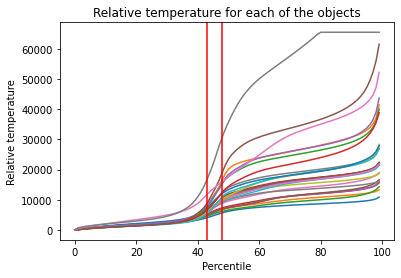

In [15]:
xs = np.arange(0, 100)
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    plt.plot(xs, np.percentile(integrals[:,object.ystart:object.yend, object.xstart:object.xend], xs))
plt.axvline(x=43, color='r', linestyle='-')
plt.axvline(x=48, color='r', linestyle='-')
plt.xlabel("Percentile")
plt.ylabel("Relative temperature")
plt.title("Relative temperature for each of the objects")

Lets sharpen the image and then filter out all background pixels and set them to nan

/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_4338/3708593478.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


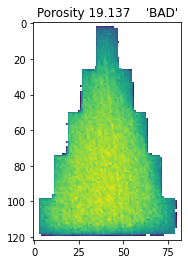

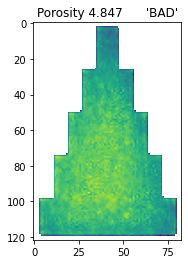

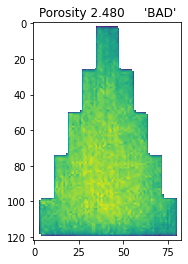

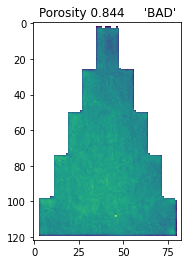

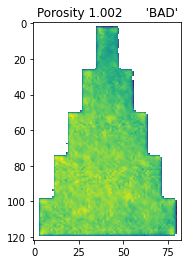

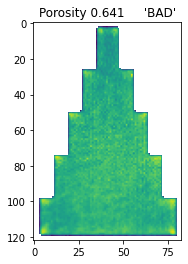

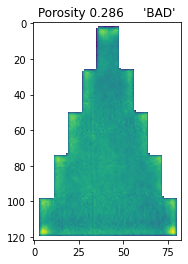

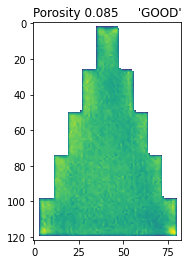

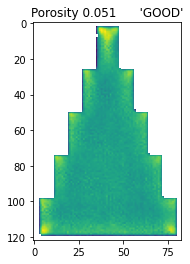

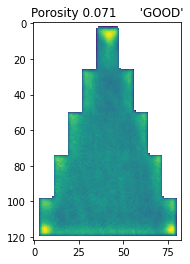

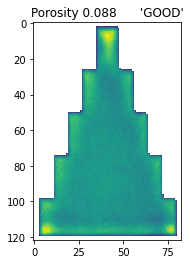

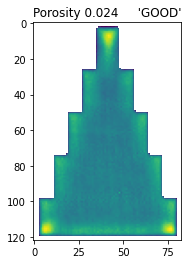

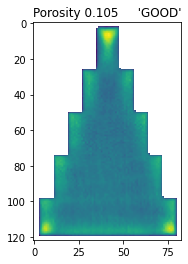

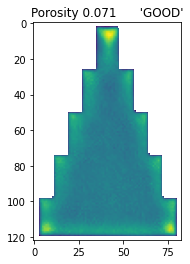

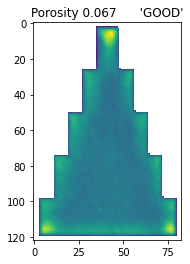

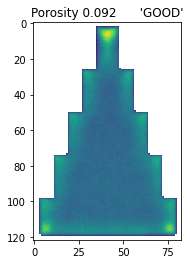

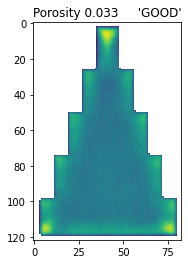

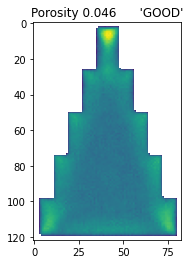

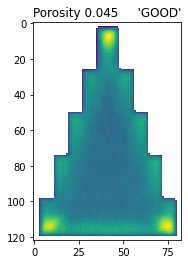

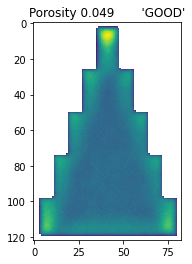

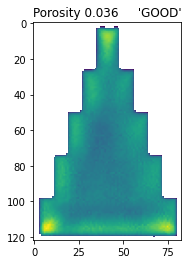

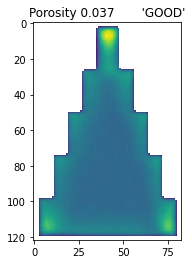

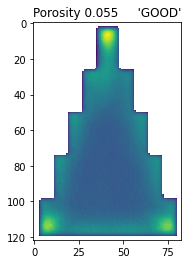

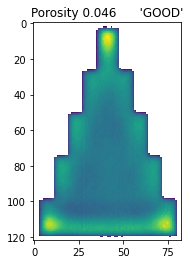

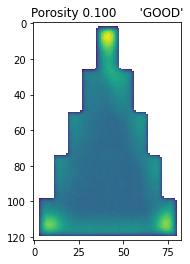

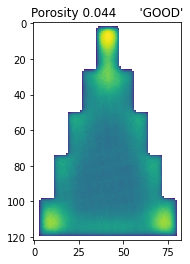

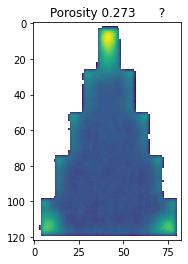

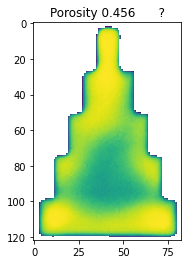

<Figure size 432x288 with 0 Axes>

In [22]:
import cv2
# Sharpening
sharpeningKernel = np.array([   [ 0, -1,  0],
                                [-1,  5, -1],
                                [ 0, -1,  0]
                            ])
sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in integrals])
# End of sharpening
# Start of filtering
# A better approach to filtering would be some sort of clustering or image segmentation
emptyRatio = 47
filtered = np.full(np.shape(integrals), np.nan)
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    sum = np.sum(sharpened[:, object.ystart:object.yend, object.xstart:object.xend], axis=0)
    limit = np.percentile(sum, emptyRatio)
    filter = sum >= limit
    avg = np.mean(sum, where=filter)
    stddev = np.std(sum, where=filter)
    sum = (sum - avg) / avg
    sum[~filter] = np.nan
    plt.imshow(sum)
    plt.title("Porosity " + object.Porosity)
    plt.figure()
    filtered[:, object.ystart:object.yend, object.xstart:object.xend] = sum


Now, let's calculate the neighbourhood matrix

187


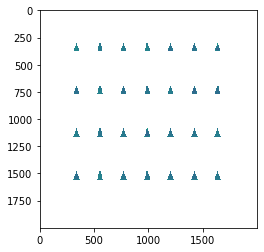

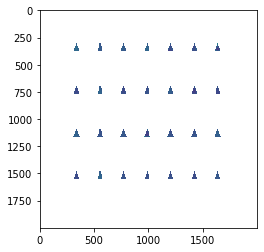

In [23]:

windowSize = 7
# This could also be a gaussian
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
plt.imshow(filtered[93])
plt.figure()
veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in filtered])
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
del veryBlurredLayers
plt.imshow(neighbourhoodValues[93])

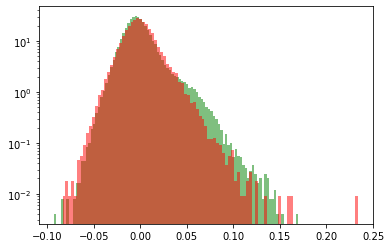

In [29]:
poorx = []
poory = []
goodx = []
goody = []
hotx = []
hoty = []

goodcount = 0
poorcount = 0
hotcount = 0

def flatten(xss):
    return [x for xs in xss for x in xs]
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = filtered[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
    ys = neighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
    filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
    line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
    p = np.poly1d(line)
    if object.Porosity > 0.2:
        if object.VED < 35:
            poorx.append((xs-p(ys)).flatten())
            poorcount += 1
        else:
            hotx.append((xs-p(ys)).flatten())
            hotcount += 1
    else:
        goodx.append((xs-p(ys)).flatten())
        goodcount += 1
plt.hist(flatten(goodx), density=True, bins=100, color='g', alpha=0.5)
plt.hist(flatten(poorx), density=True, bins=100, color='r', alpha=0.5)
# plt.hist(flatten(hotx), bins=10, color='b', alpha=0.5)
plt.yscale('log')


In [40]:
# This could be cleaned up and simplified

def flatten(xss):
    return [x for xs in xss for x in xs]
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0
X = np.array([])
Y = np.array([])
init = False

for index, object in objectinfo.iterrows():
    if object.Label == "KH":
        print("Skipping...")
        continue
    xs = filtered[windowSize:, object.ystart:object.yend, object.xstart:object.xend]
    ys = neighbourhoodValues[:, object.ystart:object.yend, object.xstart:object.xend]
    filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
    line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
    p = np.poly1d(line)
    label = object.Label
    hist, _ = np.histogram(xs-p(ys), bins=40, range=(-0.5, 2))
    if init == False:
        X = np.array([hist])
        Y = np.array([label])
        init = True
    else:
        X = np.append(X, np.array([hist]), 0)
        Y = np.append(Y, np.array([label]), 0)

from sklearn import neighbors
from sklearn.model_selection import cross_val_score, LeaveOneOut
loo = LeaveOneOut()
# for train_index, test_index in loo.split(X):
#     print("train_index: ", train_index, "test_index:", test_index)
for n_neighbors in range(2,5):
    for weights in ["uniform", "distance"]:
        print("Neighbours " + str(n_neighbors) + " weights " + weights)
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        scores = cross_val_score(clf, X, Y, cv=loo.split(X))
        print(scores)
        print("%0.2f accuracy" % (scores.mean()))

Skipping...
Skipping...
Neighbours 2 weights uniform
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
0.92 accuracy
Neighbours 2 weights distance
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 1.]
0.85 accuracy
Neighbours 3 weights uniform
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
0.96 accuracy
Neighbours 3 weights distance
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1.]
0.92 accuracy
Neighbours 4 weights uniform
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
0.96 accuracy
Neighbours 4 weights distance
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
0.96 accuracy
